
# Student Performance


## 1. Load and Explore the Dataset

In [1]:
import os, pandas as pd
csv_path = "Student_Performance.csv"

df = pd.read_csv(csv_path)
print("Shape (rows, cols):", df.shape)
display(df.head())

Shape (rows, cols): (10000, 6)


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [2]:
display(df.info())
display(df.describe(include='all').T)

# Duplicates
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)
if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicates dropped. New shape:", df.shape)

# Unique counts per column
display(pd.DataFrame({
    "unique_count": df.nunique(),
    "dtype": df.dtypes
}))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hours Studied,10000.0,NaN,NaN,NaN,4.9929,2.589309,1.0,3.0,5.0,7.0,9.0
Previous Scores,10000.0,NaN,NaN,NaN,69.4457,17.343152,40.0,54.0,69.0,85.0,99.0
Extracurricular Activities,10000,2,No,5052,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep Hours,10000.0,NaN,NaN,NaN,6.5306,1.695863,4.0,5.0,7.0,8.0,9.0
Sample Question Papers Practiced,10000.0,NaN,NaN,NaN,4.5833,2.867348,0.0,2.0,5.0,7.0,9.0
Performance Index,10000.0,NaN,NaN,NaN,55.2248,19.212558,10.0,40.0,55.0,71.0,100.0


Duplicate rows: 127
Duplicates dropped. New shape: (9873, 6)


,unique_count,dtype
Hours Studied,9,int64
Previous Scores,60,int64
Extracurricular Activities,2,object
Sleep Hours,6,int64
Sample Question Papers Practiced,10,int64
Performance Index,91,float64


### 1.1 Basic Visualizations

In [3]:
import matplotlib.pyplot as plt
import numpy as np
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']
Categorical columns: ['Extracurricular Activities']


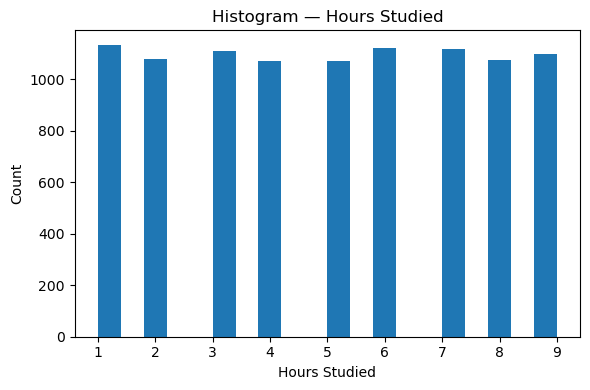

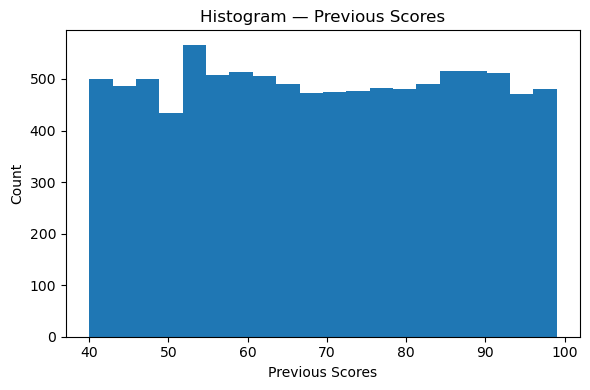

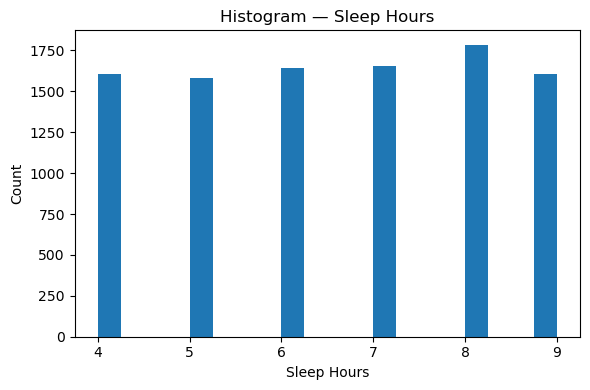

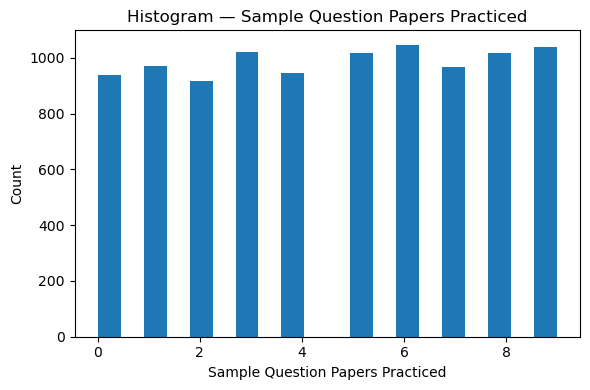

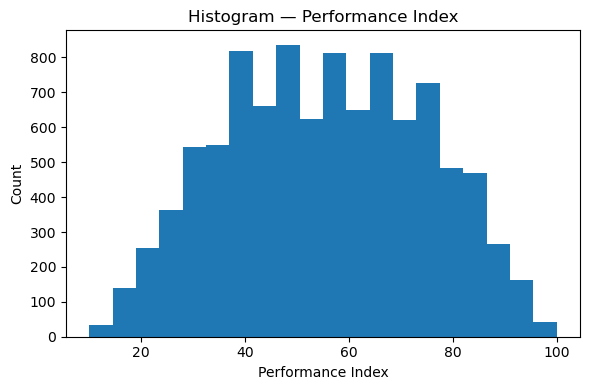

In [4]:
# Histograms for numeric columns
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=20)
    plt.title(f"Histogram — {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

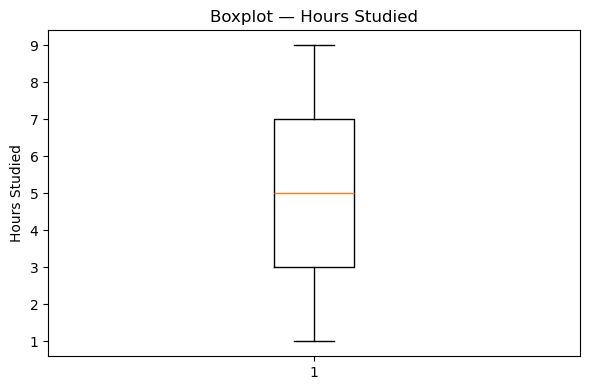

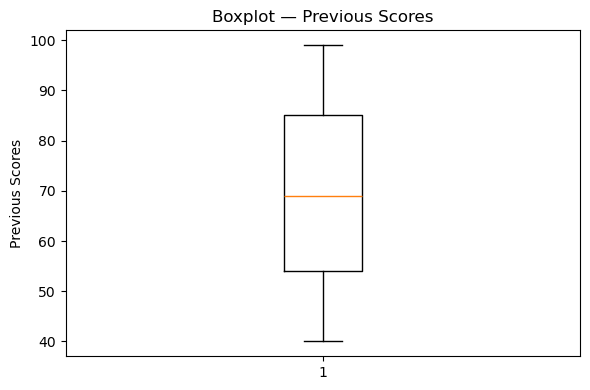

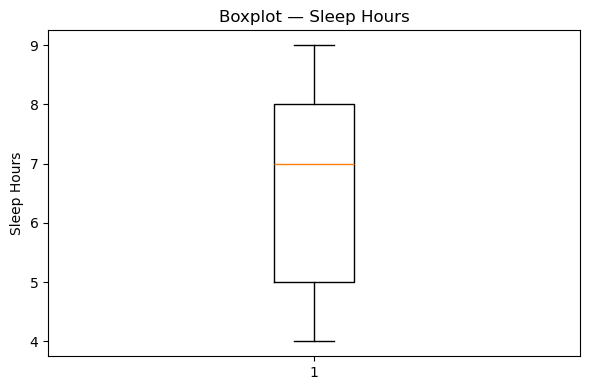

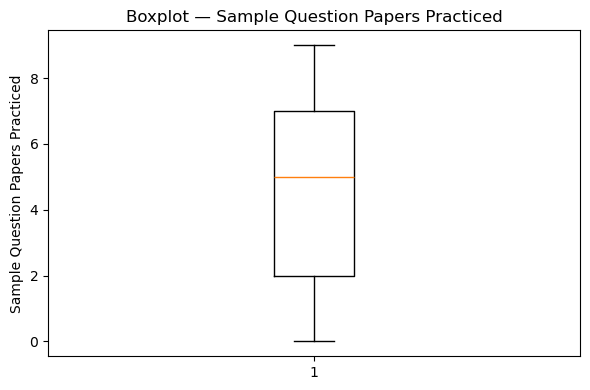

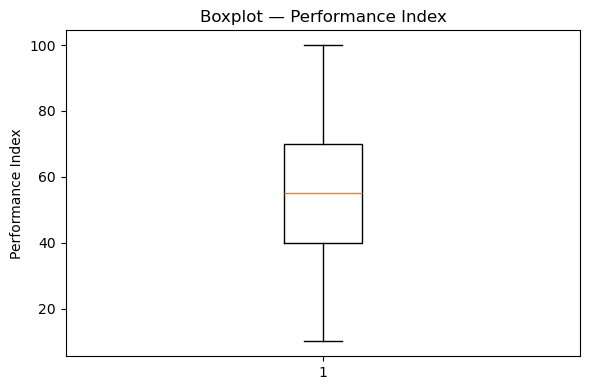

In [5]:
# Boxplots for numeric columns
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.boxplot(df[col].dropna(), vert=True)
    plt.title(f"Boxplot — {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

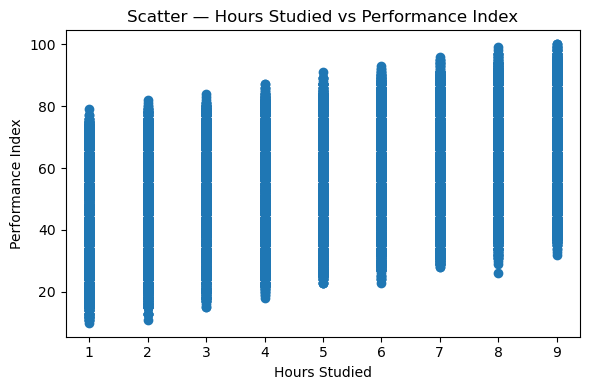

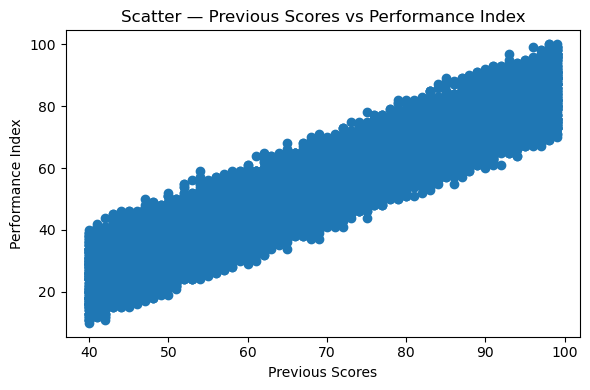

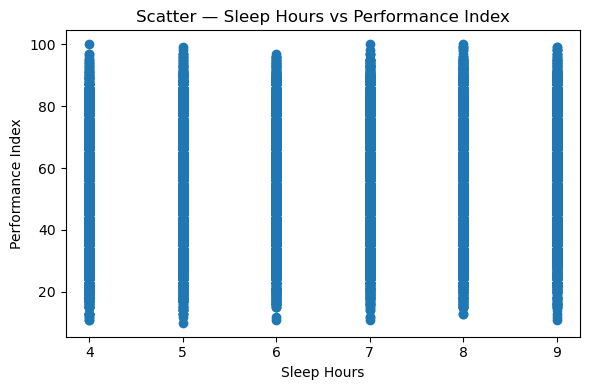

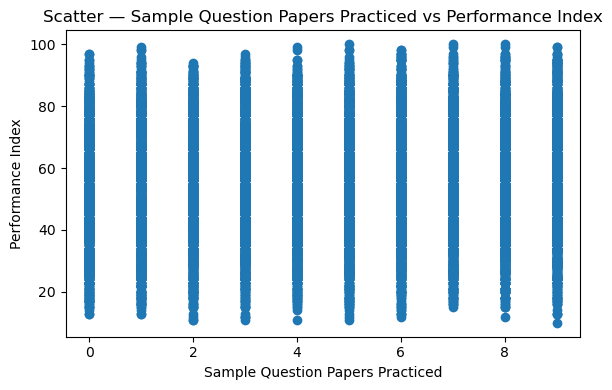

In [6]:
TARGET = "Performance Index"

if TARGET is not None:
    for col in numeric_cols:
        if col != TARGET:
            plt.figure(figsize=(6,4))
            plt.scatter(df[col], df[TARGET])
            plt.title(f"Scatter — {col} vs {TARGET}")
            plt.xlabel(col)
            plt.ylabel(TARGET)
            plt.tight_layout()
            plt.show()

### 1.2 Correlation Heatmap

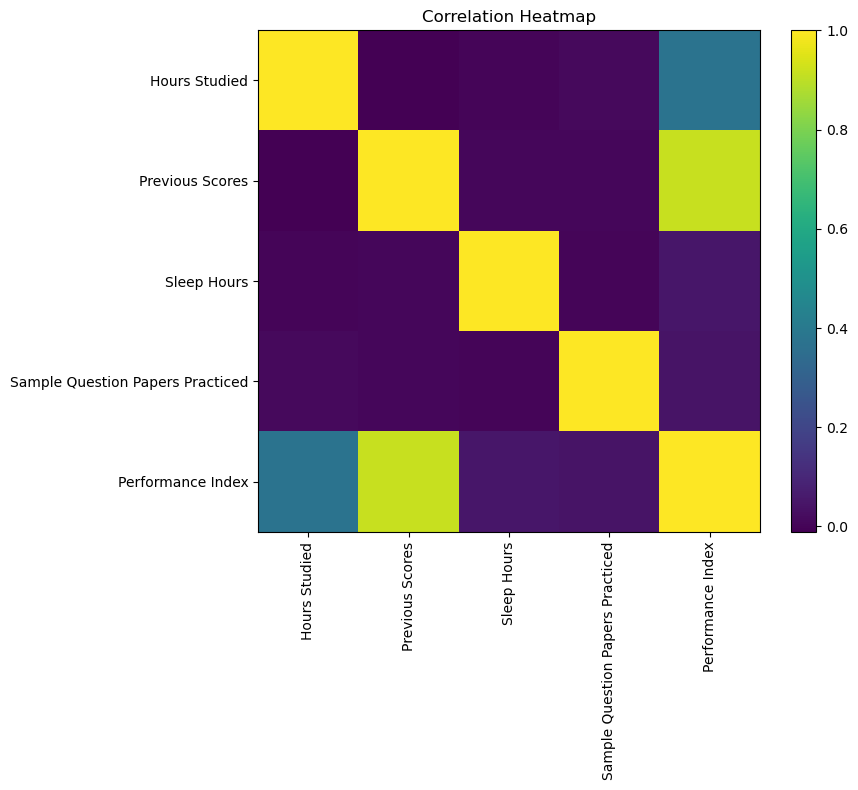

In [7]:
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,8))
im = plt.imshow(corr, interpolation='nearest')
plt.title("Correlation Heatmap")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) Target column (explicit)
TARGET = "Performance Index"
assert TARGET in df.columns, f"Target '{TARGET}' not found. Columns: {list(df.columns)}"

# 2) Basic cleaning (optional but safe)
#    - Strip column names
df.columns = [c.strip() for c in df.columns]
#    - Drop duplicate rows
if df.duplicated().sum() > 0:
    df = df.drop_duplicates().reset_index(drop=True)

# 3) Handle the only categorical feature
categorical_cols = ["Extracurricular Activities"]
for c in categorical_cols:
    assert c in df.columns, f"Expected categorical column '{c}' not found."

# Convert to one-hot (Yes/No -> 0/1), drop_first to avoid dummy trap
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 4) Separate features and target
X = df_encoded.drop(columns=[TARGET])
y = df_encoded[TARGET]

# 5) Simple NA handling (if any)
#    Numeric: fill with column mean
num_cols = X.select_dtypes(include=[np.number]).columns
if X[num_cols].isnull().any().any():
    X[num_cols] = X[num_cols].fillna(X[num_cols].mean())

#    Target: drop rows with missing target (rare, but guard anyway)
if y.isnull().any():
    keep_idx = ~y.isnull()
    X, y = X.loc[keep_idx], y.loc[keep_idx]

# 6) Train/test split (80/20, reproducible)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 7) Normalization (fit on train, apply to test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 8) Keep feature names for later inspection of coefficients
feature_names = X.columns.tolist()

# 9) Quick diagnostics
print("TARGET:", TARGET)
print("Encoded feature columns:", feature_names)
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Scaled arrays:", X_train_scaled.shape, X_test_scaled.shape)
print("Example encoded categorical col present?:",
      [c for c in feature_names if "Extracurricular Activities_" in c])


TARGET: Performance Index
Encoded feature columns: ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Extracurricular Activities_Yes']
Train shape: (7898, 5) | Test shape: (1975, 5)
Scaled arrays: (7898, 5) (1975, 5)
Example encoded categorical col present?: ['Extracurricular Activities_Yes']


## 3. Normalization (Standardization)

In [9]:

from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit only on train
X_test_scaled  = scaler.transform(X_test)       # transform test with train-fitted scaler

print("Train means (per feature) — before scaling:", np.mean(X_train.values, axis=0)[:5], "...")
print("Train means (per feature) — after scaling:", X_train_scaled.mean(axis=0)[:5], "...")
print("Train stds   (per feature) — after scaling:", X_train_scaled.std(axis=0, ddof=0)[:5], "...")


Train means (per feature) — before scaling: [4.9903773107115725 69.32983033679413 6.543935173461636 4.597872879209927
 0.4969612560141808] ...
Train means (per feature) — after scaling: [-2.51901704e-17 -3.76503083e-16  1.91625225e-16 -5.93768303e-17
  9.17641923e-17] ...
Train stds   (per feature) — after scaling: [1. 1. 1. 1. 1.] ...


## 4. Build the Regression Model (LinearRegression)

In [10]:

from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

# Coefficients (on scaled features)
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": linreg.coef_
}).sort_values(by="Coefficient", ascending=False)

display(coef_df.head(20))
display(coef_df.tail(20))


,Feature,Coefficient
1,Previous Scores,17.619931
0,Hours Studied,7.373316
2,Sleep Hours,0.802138
3,Sample Question Papers Practiced,0.540053
4,Extracurricular Activities_Yes,0.286906


,Feature,Coefficient
1,Previous Scores,17.619931
0,Hours Studied,7.373316
2,Sleep Hours,0.802138
3,Sample Question Papers Practiced,0.540053
4,Extracurricular Activities_Yes,0.286906


## 5. Evaluate the Model

In [11]:

from sklearn.metrics import mean_squared_error, r2_score

y_pred = linreg.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2 : {r2:.4f}")


MSE : 4.3059
RMSE: 2.0751
R^2 : 0.9884
